## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Import libraries for the model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'wind_elec_gen'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get_tag_names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
name

['h_6hrain',
 'h_6hsnow',
 'h_humidity',
 'h_rainprobability',
 'h_raintype',
 'h_seawave',
 'h_skystatus',
 'h_temperature',
 'h_winddirection',
 'h_windspeed',
 'hk1_1',
 'hk1_2',
 'hk1_3',
 'hk2_1',
 'hk2_2',
 'hk2_3',
 'hk2_4',
 'hk2_5',
 's_6hrain',
 's_6hsnow',
 's_humidity',
 's_rainprobability',
 's_raintype',
 's_seawave',
 's_skystatus',
 's_temperature',
 's_winddirection',
 's_windspeed',
 'ss_1',
 'ss_10',
 'ss_2',
 'ss_3',
 'ss_4',
 'ss_5',
 'ss_6',
 'ss_7',
 'ss_8',
 'ss_9']

## Converting TAG Name Format
* After checking all the Tag Names from the Wind Elec Gen dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use tag names related to the Hankyung Power Plant No. 1

In [5]:
# Set the desired tag names
tags = name[:13]

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

'h_6hrain','h_6hsnow','h_humidity','h_rainprobability','h_raintype','h_seawave','h_skystatus','h_temperature','h_winddirection','h_windspeed','hk1_1','hk1_2','hk1_3'


## Load Wind Electric Generation Dataset
* Load the data using tag names related to the Hankyung Power Plant No. 1

In [6]:
# Data loading parameter settings

# Set the tag table name
table = 'wind_elec_gen'
# Set the tag names
name = quote(tags_, safe=":/")
# Set the time format 
timeformat = 'default'
# Set the data start time
start_time = quote('2014-01-01 06:00:00')
# Set the data end time
end_time = quote('2018-01-01 03:00:00')

In [7]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')

    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()

    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'])

    # Set time index
    df.set_index('TIME', inplace=True)

    # Resample at 3-hour intervals
    df = df.resample('3H').mean()

    # Remove missing values
    df = df.dropna()

    # Merge power generation
    # Sum the power generation from Hankyung Power Plant 1, 2, and 3
    df.loc[:, 'hk1_total'] = df.iloc[:, 10:].sum(axis=1)

    return df

In [8]:
# Load data
df = data_load(table, name, start_time, end_time, timeformat)
df

NAME,h_6hrain,h_6hsnow,h_humidity,h_rainprobability,h_raintype,h_seawave,h_skystatus,h_temperature,h_winddirection,h_windspeed,hk1_1,hk1_2,hk1_3,hk1_total
TIME,,,,,,,,,,,,,,
2014-01-01 06:00:00,0.0,0.0,43.0,0.0,0.0,1.5,1.0,12.1,285.0,8.1,1327.916667,-4.666667,1328.900000,2652.150000
2014-01-01 09:00:00,0.0,0.0,50.0,0.0,0.0,1.0,1.0,10.6,285.0,8.0,849.011111,345.961111,813.372222,2008.344444
2014-01-01 12:00:00,0.0,0.0,50.0,0.0,0.0,1.0,1.0,10.2,278.0,8.2,543.388889,522.255556,533.427778,1599.072222
2014-01-01 15:00:00,0.0,0.0,50.0,0.0,0.0,1.0,1.0,8.4,281.0,6.9,489.533333,472.450000,461.377778,1423.361111
2014-01-01 18:00:00,0.0,0.0,50.0,0.0,0.0,1.0,1.0,8.0,298.0,6.4,369.827778,266.494444,342.866667,979.188889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-09 18:00:00,0.0,0.0,65.0,20.0,0.0,0.5,3.0,10.0,220.0,5.1,170.116667,169.338889,144.744444,484.200000
2017-12-09 21:00:00,0.0,0.0,65.0,20.0,0.0,0.5,3.0,10.0,223.0,5.3,267.794444,435.411111,416.900000,1120.105556
2017-12-10 00:00:00,5.0,0.0,70.0,60.0,0.0,1.0,4.0,11.0,254.0,5.8,484.464706,669.894118,702.876471,1857.235294


In [9]:
# Split the data into train, validation, and test sets
# Validation data from 2016, test data from 2017, and training data consists of data from before 2016.

train = df[df.index.year < 2016]
valid = df[df.index.year == 2016]
test = df[df.index.year == 2017]

## Data Preprocessing
* Apply MinMaxScaler to each dataset.
* Apply to both input data and target data separately to facilitate conversion back to original values after testing. 

### Applying MinMaxScaler

In [10]:
# Set up scalers
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()

# Apply scalers
train_ = scaler_data.fit_transform(train.iloc[:, :-1].values)
train_t = scaler_target.fit_transform(train.iloc[:, -1:].values)

valid_ = scaler_data.transform(valid.iloc[:, :-1].values)
valid_t = scaler_target.transform(valid.iloc[:, -1:].values)

test_ = scaler_data.transform(test.iloc[:, :-1].values)
test_t = scaler_target.transform(test.iloc[:, -1:].values)

# Set up DataFrame
train_scaled = pd.DataFrame(train_)
train_scaled['total'] = train_t

valid_scaled = pd.DataFrame(valid_)
valid_scaled['total'] = valid_t

test_scaled = pd.DataFrame(test_)
test_scaled['total'] = test_t

## Dataset & Loader Setup

### Window Dataset Configuration
* To train on time series data, you need to set the window size and the sliding step.

* Window size: Determines how many time points to group together.
* Step size: The time interval by which the window moves.

In [11]:
# Sliding Window Dataset Configuration
class SlidingWindowDataset(Dataset):
    def __init__(self, data, window_size, step_size):
        self.data = data
        self.window_size = window_size
        self.step_size = step_size
        self.windows, self.targets = self._create_windows()
    
    # Set up sliding windows
    def _create_windows(self):
        windows = []
        targets = []
        for i in range(0, len(self.data) - self.window_size + 1, self.step_size):
            window = self.data.iloc[i:i + self.window_size, :-1].values  # Exclude the last column
            target_array = self.data.iloc[i:i + self.window_size, -1].values  # The last column is the target
                
            windows.append(torch.Tensor(window))
            targets.append(torch.Tensor(target_array))  # Convert target to Tensor
        return windows, targets
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return self.windows[idx], self.targets[idx]

In [12]:
# Sliding window configuration
window_size = 8
step_size = 1 

# Set up datasets 
train_ = SlidingWindowDataset(train_scaled, window_size, step_size)
valid_ = SlidingWindowDataset(valid_scaled, window_size, step_size)
test_ = SlidingWindowDataset(test_scaled, window_size, step_size)

# Set up data loaders
train_dataloader = DataLoader(train_, batch_size=16, shuffle=False)
valid_dataloader = DataLoader(valid_, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_, batch_size=16, shuffle=False)

In [13]:
# Verify DataLoader application and check the shape of the input data
print(list(train_dataloader)[0][0].shape)

torch.Size([16, 8, 13])


## Model Configuration
* Using LSTM AE model.

In [14]:
# LSTM Autoencoder class definition
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, int(hidden_dim/2))
        
        # Decoder LSTM
        self.decoder_fc = nn.Linear(int(hidden_dim/2), hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)
        
        # Fully Connected Layer settings
        self.fc1 = nn.Linear(input_dim, 6)
        self.fc2 = nn.Linear(6, 1)

    def forward(self, x):
        # Encoder part
        _, (h, _) = self.encoder_lstm(x)
        latent = self.encoder_fc(h[-1])
        
        # Decoder part
        hidden = self.decoder_fc(latent).unsqueeze(0).repeat(x.size(1), 1, 1).permute(1, 0, 2)
        output, _ = self.decoder_lstm(hidden)
        
        # Fully Connected Layer
        output = self.fc1(output)
        output = self.fc2(output)
        return output

In [15]:
# Model configuration parameters

# number of input data columns
# last number in print(list(train_dataloader)[0][0].shape)
input_dim = 13

# LSMT hidden state size
hidden_dim = 6

# layer size
num_layers = 2

# Learning rate
learning_rate = 0.001

# Model configuration
model = LSTMAutoencoder(input_dim, hidden_dim, num_layers).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

LSTMAutoencoder(
  (encoder_lstm): LSTM(13, 6, num_layers=2, batch_first=True)
  (encoder_fc): Linear(in_features=6, out_features=3, bias=True)
  (decoder_fc): Linear(in_features=3, out_features=6, bias=True)
  (decoder_lstm): LSTM(6, 13, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=13, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
)


## Model Training

* Save the model with the Best Loss based on the validation data during training.

In [16]:
# Initialize loss
train_loss = []
valid_loss = []
# Initialize total step
total_step = len(train_dataloader)
total_step_ = len(valid_dataloader)
# Set number of epochs
epoch_in = trange(100, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:
    model.to(device)
    model.train()
    running_loss = 0.0

    for batch_idx, train_data in enumerate(train_dataloader):

        inputs = train_data[0].to(device).float()
        target = train_data[1].to(device).float()

        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')
    
    # Perform validation at the end of each epoch and save the model with the best performance 
    with torch.no_grad():
        model.eval()
        running_loss_ = 0.0
        
        for batch_idx, valid_data in enumerate(valid_dataloader):
            
            inputs_ = valid_data[0].to(device).float()
            target_ = valid_data[1].to(device).float()

            outputs_ = model(inputs_)
            
            loss_ = criterion(outputs_.squeeze(), target_)
            
            running_loss_ += loss_.item()
            
        valid_loss.append(running_loss_/total_step_)    

    # Save the best model
    if best_Loss > np.mean(valid_loss):
        best_Loss = np.mean(valid_loss)
        torch.save(model, f'./result/Wind_Elec_Gen_General.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.10497798808733219
Model saved


c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 8])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



train loss: 0.07009734050156492
Model saved

train loss: 0.05669249567678885
Model saved

train loss: 0.049581676118025504
Model saved

train loss: 0.045194014430526744
Model saved

train loss: 0.04221041940257931
Model saved

train loss: 0.03963830807391609
Model saved

train loss: 0.03658906462113043
Model saved

train loss: 0.03393602749237281
Model saved

train loss: 0.031726155835246676
Model saved

train loss: 0.029874271303527947
Model saved

train loss: 0.02830658092610833
Model saved

train loss: 0.026967094588272726
Model saved

train loss: 0.025805254146957373
Model saved

train loss: 0.024788053555734043
Model saved

train loss: 0.02389106182117813
Model saved

train loss: 0.02309332792600077
Model saved

train loss: 0.022380577562833032
Model saved

train loss: 0.02173865216391254
Model saved

train loss: 0.021157986733682924
Model saved

train loss: 0.020629771659825387
Model saved

train loss: 0.02014707549242262
Model saved

train loss: 0.019704050160345307
Model saved

## Model Testing

In [17]:
# Load the best model
model_ = torch.load(f'./result/Wind_Elec_Gen_General.pt')

In [18]:
# Model testing
output_test = []
with torch.no_grad():
    model_.eval()
    running_loss_t = 0.0
    
    for batch_idx, test_data in enumerate(test_dataloader):
        
        inputs_t = test_data[0].to(device).float()
        target_t = test_data[1].to(device).float()

        outputs_t = model_(inputs_t)
        
        output_test.append(outputs_t)
        
# Combine tensors into one
combined_tensor = torch.cat(output_test, dim=0)

# Use only the last value of the window
last_values = combined_tensor[:, -1, :].cpu()

# Transform back to the original data format
# Inverse transform using MinMaxScaler
last_values_ = scaler_target.inverse_transform(last_values)

# Create a DataFrame for the results
final_scaled = pd.DataFrame(test_scaled.iloc[7:,-1:].values, columns=['real'])
final_scaled['pred'] = last_values

final = pd.DataFrame(test.iloc[7:, -1:].values, columns=['real'])
final['pred'] = last_values_

## Model Performance Evaluation

In [19]:
# Calculate MSE
mse = mean_squared_error(final_scaled['real'].values, final_scaled['pred'].values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(final['real'].values, final['pred'].values)
print("R² Score:", r2)

Mean Squared Error: 0.004653917329540123
R² Score: 0.944772949282327


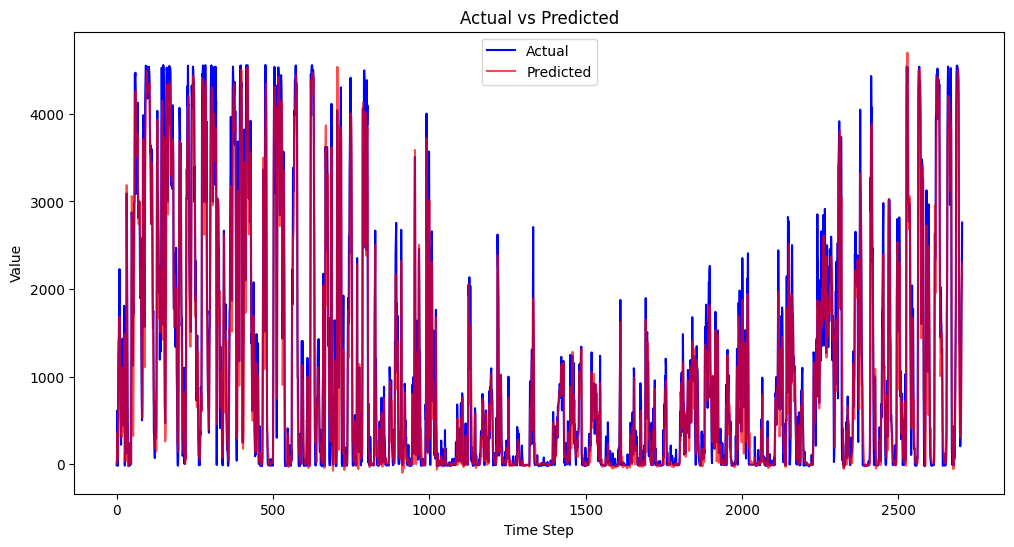

In [20]:
# Compare the test results: Actual values vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(final['real'].values, label='Actual', color='blue')
plt.plot(final['pred'].values, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()